<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Projekt 2: Epidemieausbreitung
</b></p>
<p style="font-size:25px; color: #3776ab; text-align:center">
Populationsdynamik & Netzwerke
</p>
<br>
<p style="font-size:15px; text-align:center">
von Lorenz Saalmann, Jonathan Fimmen und Peter Preisler (8102359)
<br>begleitet durch Leon Sieke
</p>
<br>

# Inhaltsverzeichnis

1. Einführung
2. Verwendetes Modell
3. Grundlegende Implementation
4. Test des Grundmodells
5. Erweiterung des Modells
6. Abschließende Ergebnisse und Tests

# 1. Einführung

Das Jahr 2020 wird für zukünftige Generationen wohl fest mit der Covid-19-Pandemie verbunden sein. Die globalisierte Welt in Verbindung mit einem passend ausgestatteten Virus haben dafür gesorgt, dass das öffentliche Leben zeitweise nahezu vollständig eingestellt werden musste, um die Ausbreitung aufzuhalten. Dadurch wurde der Menschheit aufgezeigt, wie wichtig es ist die Ausbreitungsdynamik beliebiger Krankheiten zu verstehen. Denn nur dann können passende und wirksame Maßnahmen getroffen werden, um den Verlauf zu kontollieren. Da sich unglaublich viele Faktoren auf diese Dynamik auswirken, sollten Vorbereitungen getroffen werden um möglichst realistische Modelle zu entwickeln. 

In dieser Arbeit werden zwei Modelle miteinander kombiniert. Die Ansteckungen werden mithilfe des SIR-Modells (Susceptible-Infected-Recovered) beschrieben, während die Reisebewegungen unter Verwendung eines Diffusionsmodells eingebracht werden. Die daraus resultierenden Differentialgleichungen werden im nächsten Kapitel diskutiert. Mit dem Modell soll anschließend die Ausbreitung einer Infektionskrankheit in Europa beschrieben werden, wobei die Flughäfen mit ihren Einzugsgebieten in der SIR-Dynamik eine Identität darstellen, welche durch das Diffusionsmodell miteiander in Verbidnung stehen. Im weiteren Verlauf wird das erstellte Modell erweitert um es noch näher an die Realität anzupassen.

# 2. Verwendetes Modell

## 2.1 SIR-Modell

Wie der Name nahelegt unterscheidet das grundlegende Modell drei verschiedene Gruppen. Einmal die ansteckbare Bevölkerung $S(t)$ (Suceptible), welche durch die Krankheit infiziert werden kann. Dann die infizierte Gruppe $I(t)$ (Infected), welche derzeit mit der Krankheit infiziert ist. Und schließlich die genesenen Personen $R(t)$ (Recovered), welche nicht mehr von der Krankheit befallen und jetzt immun sind. Dabei wird zunächst nicht unterschieden, ob diese gestorben sind, oder sie die Krankheit besiegt haben. Es ergeben sich folgende Differentialgleichungen (wobei $N=S+I+R$, weshalb auch $N(t)$):

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S I}{N},\tag{1}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \beta \frac{S I}{N} -\gamma I,\tag{2}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = \gamma I\tag{3}
\end{align}

Der Parameter $\beta$ gibt dabei die Ansteckungsrate an, welche sich aus der Wahrscheinlichkeit für eine Ansteckung ergibt. Diese ist sowohl vom Virus selbst, als auch von der Exposition der Infizierten Bevölkerung abhängig.
Die Übergangsrate $\gamma$ ist hingegen durch die Inverse der durchschnittlichen Dauer der Krankheit definiert. Sie bestimmt wie schnell sich infizierte Personen wieder von der Krankheit erholen (oder sterben).

## 2.2 Diffsionsmodell

Die Grundlage des Diffusionsmodell bilden - wie oben bereits erwähnt - die Flughäfen Europas und ihre Verbindungen untereinander. Zwischen diesen Flughäfen werden Reisen der jeweiligen Gruppen modelliert. Die Diffentialgleichungen erweitern sich dadurch zu:

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = D_S \nabla^2 S -\beta \frac{S I}{N},\tag{4}\\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = D_I \nabla^2 I + \beta \frac{S I}{N} -\gamma I,\tag{5}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = D_R \nabla^2 R + \gamma I,\tag{6}
\end{align}

Die Diffusionskonstanten $D_S$, $D_I$ und $D_R$ werden zunächst als identisch angenommen. Da das betrachtete Netzwerk diskret ist ergibt sich der Laplaceoperator als:

\begin{equation}
    \nabla^2 C_i(t) = \sum_{j\sim\, i}^{\mathrm{deg}(i)}\frac{\bigl[C_j(t) - C_i(t)\bigr]}{{\mathrm{deg}(i)}},\quad \text{mit } C \in \{S, I, R\}.\tag{7}
\end{equation}

Der Normierungsfaktor $\frac{N_i}{N_j}$ findet Anwendung, da sich die Populationen der Städte unterscheiden. Ohne ihn würden sich mit der Zeit die Einwohnerzahlen aller Städte auf einen Mittelwert zubewegen.

In der folgenden Implementation wird zudem angenommen, das Reisen instantan ablaufen und auf ihnen keine Ansteckungen möglich sind. Deshalb können die Differentialgleichungen für SIR-Dynamik und Diffusionsmodell separat voneinander gelöst werden.

# 3. Grundlegende Implementation

## 3.1 Grundaufbau 

Import aller notwendigen Pakete.

In [238]:
import pandas as pd # Datenverarbeitung
import numpy as np  # Numerische Berechnungen
import matplotlib.pyplot as plt # Visualisierung
from matplotlib.animation import FuncAnimation # Animations
from IPython.display import Image # Load Animations
import cartopy.crs as ccrs # Kartenprojektionen
from scipy.integrate import solve_ivp # Numerische Lösung von Differentialgleichungen

Die grundlegenden Datensätze werden in aufbereiteter Form zur Verfügung gestellt und nun importiert.

In [239]:
# import all cleaned
airports = pd.read_csv('./datasets/cleaned_data/airports_cleaned.csv')
routes = pd.read_csv('./datasets/cleaned_data/routes_cleaned.csv')
routes_matrix = pd.read_csv('./datasets/cleaned_data/routes_matrix_cleaned.csv', index_col=0)

Erstellen der Klasse 'City', welche den momentanten Zustand einer Stadt in Hinsicht auf das SIR-Modell beinhaltet. Sie bietet zudem die Möglichkeit die Stadt mit einer Krankheit zu infizieren, oder alle Werte auf den Ausgangszustand zurückzusetzen.

In [240]:
# data class to hold infection values
class City:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.S = population
        self.I = 0
        self.R = 0
    # infects a given percent of all suceptible people
    def infect_percent(self, percent):
        self.I += self.S * percent
        self.S = self.S - self.S * percent
    # infects a total number of suceptible people
    def infect(self, newly_infected):
        self.I += newly_infected
        self.S = self.S - newly_infected
    # resets the sir-dynamic     
    def reset_city(self):
        self.S = self.population
        self.I = 0
        self.R = 0

Anschließend wird ein Dictionary erstellt, welches jedem IATA-Code die zugehörige Stadt der Klasse City zuordnet und mit den Ausgangswerten füllt. 

Für die späteren Tests der Implementation wird zugleich eine Funktion definiert, welche alle Städte auf den Ausgangszustand zurücksetzt.

In [241]:
# create a dict with iata to cities
cities = {}
for airport in (airports[['population', 'IATA']]).values:
    cities[airport[1]] = (City(airport[0], airport[1]))
 
def cure_humanity():
    # resets the sir-dynamic for all cities
    for c in cities.values():
        c.reset_city()

Es wird eine Funktion definiert die den zeitlichen Verlauf der SIR-Dynamik einer beliebigen Stadt als Plot darstellt. Dabei werden bereits drei Gruppen berücksichtigt, welche erst im erweiterten Modell betrachtet werden.

In [242]:
def plot_SIR(title, t, s, i, r, z=[], d=[], n=[], values = {}):
    # Plot SIR values
    plt.close()
    plt.plot(t, s, label='Susceptable')
    plt.plot(t, i, c='red', label='Infected')
    plt.plot(t, r, c='green', label='Recovered')
    if (len(z) > 0):
        plt.plot(t, z, c='purple', label='Incubation')
    if (len(d) > 0):
        plt.plot(t, d, c='black',label='Dead')
    if (len(n) > 0):
        plt.plot(t, n, label='Total')
    plt.xlabel('Days')
    plt.ylabel('Number of People')
    plt.title(title)

    # show all values provided underneath
    subtitle = ''
    for i, v in enumerate(values):
        if i != 0:
            subtitle += ',  '
        subtitle += fr'${v} = {round(values[v],2)}$'

    plt.figtext(.5,-.001, subtitle, fontsize=8, ha='center')
    plt.legend()
    plt.show()

## 3.2 Diffusionsmodell

Die 'routes_matrix' enthält die nach dem Alphabet sortierten IATA-Codes aller verwendeten Städte jeweils als Zeilen- und Spaltenindizes. An jedem Verknüpfungspunkt zwischen einer Stadt aus Zeile und Spalte steht eine 1, wenn zwischen beiden eine direkte Verbindung besteht, oder eine 0, wenn keine vorhanden ist. Aus diesem Grund ist die Matrix symmetrisch. 

Der Funktion wird eine Stadt übergeben, von welcher die Difussion zu allen direkt angebundenen Städten berechnet werden soll. Zudem erhält die Funktion die Diffusionskonstanten $D_S$, $D_I$ und $D_R$ als Übergabeparameter. Anschließend wird die, der übergebenen Stadt zugehörigen, SPALTE/(ZEILE)??? in der Matrix mit einer for-Schleife durchlaufen. Immer wenn eine Verbindung zu einer korrespondierenden Stadt besteht, wird die zugehörige Diffusion ausgerechnet und aufsummiert.


... Spalte oder Zeile?

In [243]:
def calculate_travel (ci : City, ds, di, dr):
    # Calculate a travel step for given city
    sumS = 0
    sumI = 0
    sumR = 0
    deg_i = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R 
        
        deg_i += 1
    
    return (ds * sumS / deg_i, di * sumI / deg_i, dr * sumR / deg_i)

## 3.3 SIR-Modell

Nun sollen mit drei verschiedenen Algorithmen die Differentialgleichungen des SIR-Modells gelöst werden. 

Das einfachste Verfahren, welches sich zur Lösung anbietet, ist das Euler-Verfahren. Bei diesem wird der Funktionswert an der Stelle $t_1$ aus der Tangentensteigung bei $t_0$ bestimmt. Dazu wird die Steigung (Ableitung an der Stelle $t_0$) mit einem Zeitschritt multipliziert, um die absolute Änderung innerhalb des Zeitschritts zu erhalten. Addiert man diese Änderung auf den Funktionswert bei $t_0$ erhält man den nächsten Funktionswert. Diese Methode ist sehr simpel, weist dafür aber auch den größten Fehler auf, wie später zu erkennen ist.

In [244]:
def calculate_SIR_euler(c : City, beta, gamma, days):
    # solves the SIR differential equations within given city for given parameters
    N = c.population
    time_step = 1
    t = []
    s = []
    i = []
    r = []

    for d in range(days):
        # append values to list
        t.append(d)
        s.append(c.S)
        i.append(c.I)
        r.append(c.R)
        
        # calculate each step
        dS_dt = -beta / N * c.S * c.I
        dI_dt = beta / N * c.S * c.I - gamma * c.I
        dR_dt = gamma * c.I
        
        # add steps multiplied by timestep
        c.S += dS_dt * time_step
        c.I += dI_dt * time_step
        c.R += dR_dt * time_step
    
    return t, s, i, r

Der Runge-Kutta-Algorithmus verbessert die Genauigkeit dadurch, dass statt einer Tangentensteigung, die Steigung von vier Tangenten berechnet wird. Diese werden ausgehend von einer Taylor-Reihe unterschiedlich gewichtet und zu einer resultierenden Steigung zusammengefasst.


... ausführlicher

In [245]:
def calculate_SIR_runge_kutta(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters
    dt = 1
    
    t_values = np.zeros(days + 1)
    S_values = np.zeros(days + 1)
    I_values = np.zeros(days + 1)
    R_values = np.zeros(days + 1)
    
    # initial conditions
    t_values[0] = 0
    S_values[0] = c.S
    I_values[0] = c.I
    R_values[0] = c.R

    b_over_n = beta / c.population
    
    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    for i in range(days):
        t = t_values[i]
        S = S_values[i]
        I = I_values[i]
        R = R_values[i]

        # Runge Kutta to the 4th order
        k1_S, k1_I, k1_R = derivatives(S, I) * dt
        k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
        k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
        k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
        # update the solution
        t_values[i+1] = t + dt
        S_values[i+1] = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
        I_values[i+1] = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
        R_values[i+1] = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    
    return t_values, S_values, I_values, R_values


Zuletzt findet die mächtige Funktion 'solve_ivp' aus der scipy-Bibliothek Anwendung. Dafür müssen lediglich die Ableitung definiert und der Funktion übergeben werden.

In [246]:
def calculate_SIR_ivp(c : City, beta, gamma, days):
    # solve the SIR differential equations within given city for given parameters

    def derivatives(t, state):
        S = state[0]
        I = state[1]
        
        N = c.population
        
        dS_dt = -beta / N * S * I
        dI_dt = beta / N * S * I - gamma * I
        dR_dt = gamma * I
        return [dS_dt, dI_dt, dR_dt]
    
    return solve_ivp(derivatives, [0, days], [c.S, c.I, c.R], max_step=1)

Vergleicht man die drei Verfahren, so erkennt man, dass das Runge-Kutta-Verfahren und die Funktion Solve_IVP identische Ergebnisse liefern. Das Euler-Verfahren weicht hingegen stark von den anderen beiden Verläufen ab. Die Genauigkeit sinkt insbesondere für niedrige initiale Infektionszahlen und geringe Ansteckungsraten $\beta$.

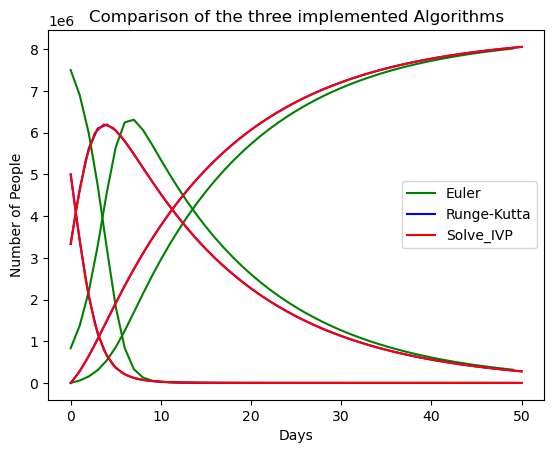

In [247]:
# infect people - intial condition
test_city = cities['LHR']
test_city.reset_city()
test_city.infect_percent(.1)
beta = 0.8
gamma = 0.07
days = 50

plt.close()
# plot euler
t, s, i, r = calculate_SIR_euler(test_city, beta, gamma, days)
plt.plot(t, s, c='green')
plt.plot(t, i, c='green')
plt.plot(t, r, c='green', label='Euler')

# reset city again, because euler-method overwrites values
test_city.reset_city()
test_city.infect_percent(.4)

#plot runge-kutta
t, s, i, r = calculate_SIR_runge_kutta(test_city, beta, gamma, days)
plt.plot(t, s, c='blue')
plt.plot(t, i, c='blue')
plt.plot(t, r, c='blue', label='Runge-Kutta')

# plot ivp
sol = calculate_SIR_ivp(test_city, beta, gamma, days)
plt.plot(sol.t, sol.y[0], c='red')
plt.plot(sol.t, sol.y[1], c='red')
plt.plot(sol.t, sol.y[2], c='red', label='Solve_IVP')

plt.xlabel('Days')
plt.ylabel('Number of People')
plt.title('Comparison of the three implemented Algorithms')
plt.legend()
plt.show()

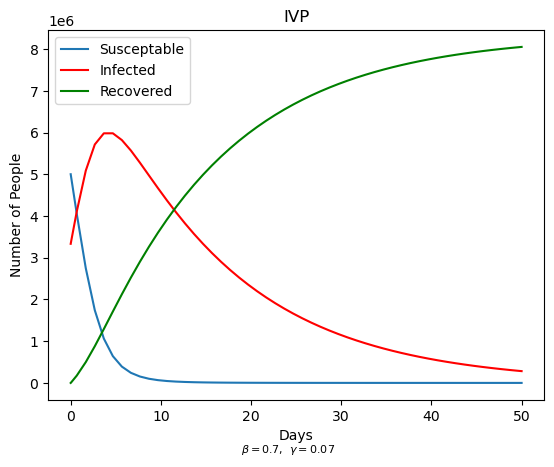

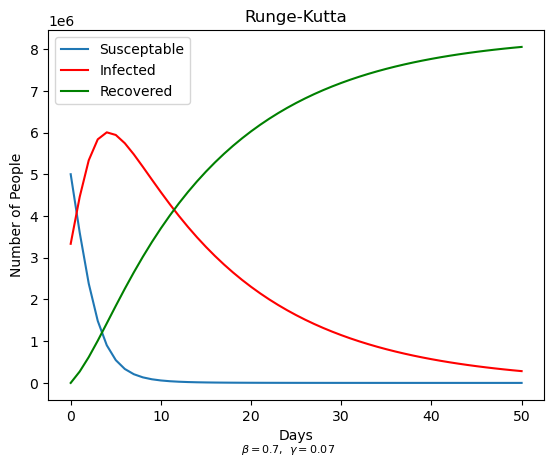

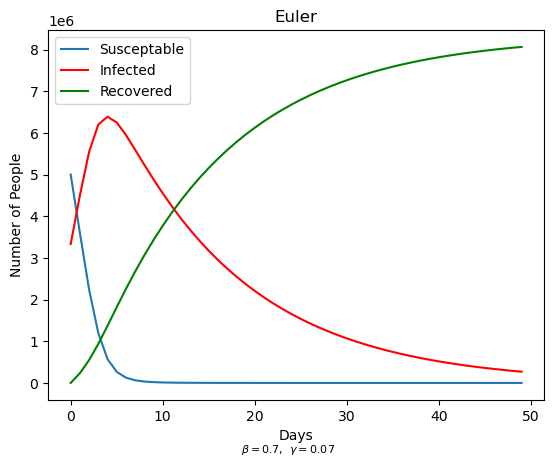

In [248]:
# infect people - intial condition
test_city = cities['LHR']
test_city.reset_city()
test_city.infect_percent(.4)
beta = 0.7
gamma = 0.07
days = 50

# ivp
sol = calculate_SIR_ivp(test_city, beta, gamma, days)
plot_SIR('IVP', sol.t, sol.y[0], sol.y[1], sol.y[2], values = {r'\beta': beta, r'\gamma': gamma})

# runge-kutta
t, s, i, r = calculate_SIR_runge_kutta(test_city, beta, gamma, days)
plot_SIR('Runge-Kutta', t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})

# euler
t, s, i, r = calculate_SIR_euler(test_city, beta, gamma, days)
plot_SIR('Euler', t, s, i, r, values = {r'\beta': beta, r'\gamma': gamma})

Um eine Simulation mit dem Reisemodell und dem SIR Modell durchzuführen, müssen diese für jeden Tag nacheinander für einen Zeitschritt ausgeführt werden. Die Step SIR Fuktion benutzt das Runge-Kutta Verfahren, um einen Zeitschritt zu rechnen.

In [249]:
def step_SIR(c : City, beta, gamma, dt):
    # solve the SIR differential equations within given city for given parameters for 1 time step

    b_over_n = beta / c.population
    
    def derivatives(S, I):
        dS_dt = -b_over_n * S * I
        dI_dt = b_over_n * S * I - gamma * I
        dR_dt = gamma * I
        return dS_dt, dI_dt, dR_dt
    
    S = c.S
    I = c.I
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_I, k1_R = derivatives(S, I) * dt
    k2_S, k2_I, k2_R = derivatives(S + 0.5 * k1_S, I + 0.5 * k1_I) * dt
    k3_S, k3_I, k3_R = derivatives(S + 0.5 * k2_S, I + 0.5 * k2_I) * dt
    k4_S, k4_I, k4_R = derivatives(S + k3_S, I + k3_I) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

Die Combined Simulation Funktion berechnet zuerst die lokale SIR Dynamik in einer Stadt und danach die Reisebewegung zwischen den Städten. Die S, I und R Werte werden jeden Schritt in den Stadt-Objekten des cities dictionary gespeichert. Außerdem wird ein Dictionary mit iata codes zu einer Liste von S, I, R tuples sowie die Zeitschritte zurückgegeben.

In [250]:
def combined_simulation(beta, gamma, ds, di, dr, days):
    
    SIR_values = {}
    for c in cities:
        SIR_values[c] = []
    t = [0]

    # add initial state
    for c in cities.values():
        SIR_values[c.IATA].append((c.S, c.I, c.R))
        
    for i in range(days):
        for c in cities.values():
            c = step_SIR(c,beta,gamma,1)
            diff_S, diff_I, diff_R = calculate_travel (c, ds, di, dr)
            c.S += diff_S
            c.I += diff_I
            c.R += diff_R
            
            SIR_values[c.IATA].append((c.S, c.I, c.R))
            
        t.append(i+1)    
    return t, SIR_values

Nun kann diese zunächst an einer Stadt getestet werden, um zu gewährleisten, dass die SIR Berechnung immernoch funktioniert.

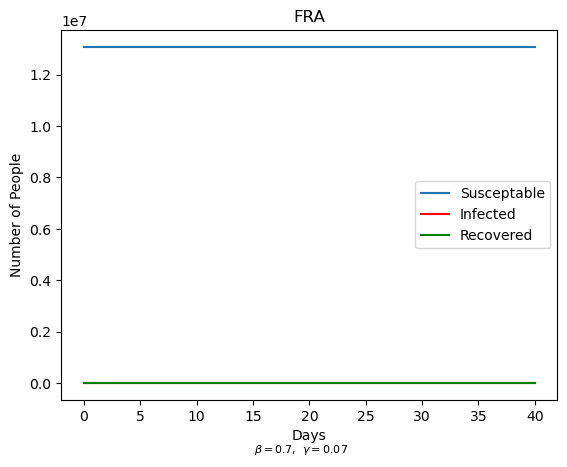

In [264]:
cure_humanity()
cities['FRA'].infect(5)
beta = 0.7
gamma = 0.07

t, SIR_values = combined_simulation(beta, gamma,0.01,0.01,0.01,40)
stadt='FRA'
S, I, R = zip(*SIR_values[stadt])

plot_SIR(stadt, t, S, I, R, values = {r'\beta': beta, r'\gamma': gamma})

Wir müssen laut Aufgabenstellung die kombinierte Funktion für alle drei Verfahren implementieren!!!

In [252]:
connection_lines = {}
city_markers = []

def initialize_plot ():
    global city_markers
    global connection_lines
    city_markers = []
    connection_lines = {}
    # Create a new map with the PlateCarree projection.
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    
    # Create a mapping from airport IATA codes to latitudes and longitudes
    airport_IATA_to_lat_lon = {row[0] : {'lat': row[1], 'lon': row[2]} for row in airports[['IATA', 'latitude', 'longitude']].values}

    # create markers and lines
    for i, city in enumerate(cities):
        pos = airport_IATA_to_lat_lon[city]
        marker = ax.plot(pos['lon'], pos['lat'], 'o', transform=ccrs.Geodetic(), c='blue', markersize = 2)
        city_markers.append(marker[0])
        
        connection_lines[i] = []
        for j in range(i):
            if routes_matrix.iloc[i, j] != 0:
                source_pos = pos
                dest_pos = airport_IATA_to_lat_lon[routes_matrix.columns[j]]
                line = ax.plot([source_pos['lon'], dest_pos['lon']],[source_pos['lat'], dest_pos['lat']],transform=ccrs.Geodetic(), c='r', alpha=0, markersize=.02)
                connection_lines[i].append((j, line[0]))
    
    
    global initialized
    initialized = True
    return ax

def plot_state(ax, SIR, day, show_routes=False):
    
    for i, city in enumerate(SIR):
        S, I, R = SIR[city][day]
        N = (S + I + R)
        infection_percent = I / N
        # update markers
        marker = city_markers[i]
        marker.set_color((I/N, R/N, S/N))
        marker.set_markersize(2 + 2 * infection_percent)

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Ij, Rj = SIR[list(SIR.keys())[j]][day]
            Nj = Sj + Ij+ Rj
            line.set(alpha = abs((N/Nj * Ij - I)) / (N) * 0.1)

In [253]:
initialized = False

def create_infection_progress_animation(SIR_values, days, title, show_routes=False):
    fig = plt.figure(figsize=(16, 9))
    if (not initialized):
        ax = initialize_plot()
    
    def update(frame):
        print(frame)
        ax.set_title(f'{title} - Day {frame}')
        plot_state(ax, SIR_values, frame, show_routes=show_routes)

    animation = FuncAnimation(fig, update, frames=days, interval=200)
    
    plt.close()
    # save animation
    animation.save("figures/infection.gif", fps=2)
   
    Image(url='figures/infection.gif')

# 5 Erweitertung des Modells



Betrachten wir einen realistischen Ablauf einer Epidemie, fällt schnell auf, dass die Simulation mittels dem SIR-Modell einige Simplifikationen aufweist. Da es unser Ziel ist, den Verlauf einer Epidemie so genau wie möglich zu bescheiben, liegt es nahe, dass wir das Modell um einige Faktoren erweitern müssen. Die Aufteilung der Bevölkerung in 3 Gruppen ist schnell nicht ausreichend, da in dem Modell nicht zwischen Verstorbenen und Genesenen Menschen unterschieden wird. Zusätzlich fehlt die Möglichkeit, dass eine bereits infizierte und genesene Person sich erneut mit der Krankheit anstecken kann. Dementsprechend haben wir im erweiterten Modell die Gruppen D (dead), R (recovered) sowie einem Verbindungsstück zwischen S und R hinzugefügt. Die Rate mit der infizierte Menschen entweder der Krankheit erliegen oder genesen wird durch den Faktor $\gamma$, sowie der Wahrscheinlichkeit aufgrund der Krankheit zu sterben $\mu$ beschrieben. Um eine mögliche Wiederansteckung mit der Krankheit zu implementieren, nutzen wir den Faktor $\lambda$, der sich aus dem Inversen der erwarteten Immunitätszeit bildet.

Um den Verlauf einer Epidemie noch genauer zu beschreiben fügen wir sowohl eine Gruppe von Menschen innerhalb der Inkubationszeit, sowie eine Gruppe von asymptomatischer Menschen hinzu. Der Faktor $\kappa$, der zur Berechnung des Übergangs von Inkubationszeit zur Infektion verwendet wird, bildet sich auf dem Inversen der durchschnittlichen Latenzzeit. Für den Asymptomatischen Verlauf verwenden wir zum einen die Wahrscheinlichkeit einer symptomatischen Verlaufs $\sigma$, sowie die Eigentschaft, dass Menschen mit asymptomatischen Verlauf nicht an der Krankheit sterben können und somit im Laufe der Krankheit direkt teil der genesenen Bevölkerung werden.

\begin{align}
    &\frac{\mathrm{d} S}{\mathrm{d} t} = -\beta \frac{S (I + A)}{N} + \lambda R,\tag{4}\\
    &\frac{\mathrm{d} Z}{\mathrm{d} t} = \beta \frac{S (I + A)}{N} - \kappa Z,\tag{5}\\
    &\frac{\mathrm{d} A}{\mathrm{d} t} = (1-\sigma)\kappa Z - \upsilon A,\tag{6} \\
    &\frac{\mathrm{d} I}{\mathrm{d} t} = \sigma \kappa Z - \gamma I,\tag{7}\\
    &\frac{\mathrm{d} D}{\mathrm{d} t} = \mu \gamma I,\tag{8}\\
    &\frac{\mathrm{d} R}{\mathrm{d} t} = (1-\mu)\gamma I + \upsilon A\tag{9}
\end{align}

Dazu werden alle benötigten Funktionen und die City class erweitert.

In [254]:
# data class to hold infection values
class ExpCity:
    def __init__(self, population, IATA):
        self.population = population
        self.IATA = IATA
        self.reset_city()
    
    def infect_percent(self, percent):
        self.Z += self.S * percent
        self.S = self.S - self.S * percent
        
    def infect(self, newly_infected):
        self.Z += newly_infected
        self.S = self.S - newly_infected
        
    def reset_city(self):
        self.S = self.population
        self.Z = 0
        self.I = 0
        self.D = 0
        self.R = 0

In [255]:
# create a new dict with iata to cities
cities_exp = {}
for airport in (airports[['population', 'IATA']]).values:
    cities_exp[airport[1]] = (ExpCity(airport[0], airport[1]))

In [256]:
def step_SZIDR(c : ExpCity, beta, gamma, _lambda, kappa, mu, dt):
    # SIR + incubation + recovered -> susceptable

    b_over_n = beta / c.population
    
    def derivatives(S, Z, I, R):
        dS_dt = -b_over_n * S * I + _lambda * R
        dZ_dt = b_over_n * S * I - kappa * Z
        dI_dt = - gamma * I + kappa * Z
        dD_dt = mu * gamma * I
        dR_dt = (1-mu) * gamma * I - _lambda * R
        

        return dS_dt, dZ_dt, dI_dt, dD_dt, dR_dt
    
    S = c.S
    Z = c.Z
    I = c.I
    D = c.D
    R = c.R
    
    # Runge Kutta to the 4th order
    k1_S, k1_Z, k1_I, k1_D, k1_R = derivatives(S, Z, I, R) * dt
    k2_S, k2_Z, k2_I, k2_D, k2_R = derivatives(S + 0.5 * k1_S, Z + 0.5 * k1_Z, I + 0.5 * k1_I, R + 0.5 * k1_R) * dt
    k3_S, k3_Z, k3_I, k3_D, k3_R = derivatives(S + 0.5 * k2_S, Z + 0.5 * k2_Z, I + 0.5 * k2_I, R + 0.5 * k2_R) * dt
    k4_S, k4_Z, k4_I, k4_D, k4_R = derivatives(S + k3_S, Z + k3_Z, I + k3_I, R + k3_R) * dt
        
    # update the city
    c.S = S + (1/6) * (k1_S + 2*k2_S + 2*k3_S + k4_S)
    c.Z = Z + (1/6) * (k1_Z + 2*k2_Z + 2*k3_Z + k4_Z)
    c.I = I + (1/6) * (k1_I + 2*k2_I + 2*k3_I + k4_I)
    c.D = D + (1/6) * (k1_D + 2*k2_D + 2*k3_D + k4_D)
    c.R = R + (1/6) * (k1_R + 2*k2_R + 2*k3_R + k4_R)
    return c

146517.69333380027


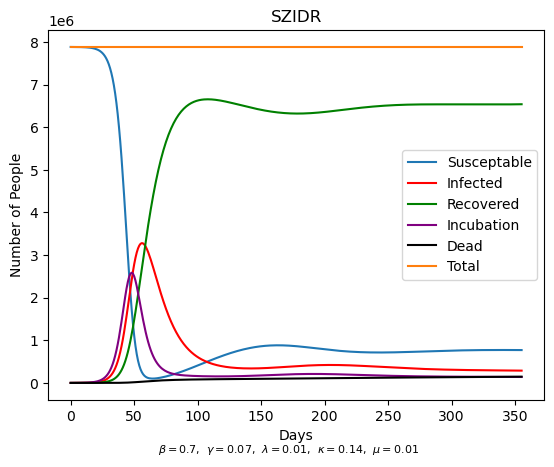

In [257]:
# infect people - intial condition
test_city = cities_exp['MUC']
test_city.reset_city()
test_city.infect(1000)

beta = 0.7
gamma = 0.07
lambda_0 = 1/90
kappa = 1/7
mu = .01

t,s,z,i,d,r = ([] for i in range(6))
total_i= 0
total = []
for n in range(356 * 1):
    t.append(n)
    s.append(test_city.S)
    z.append(test_city.Z)
    i.append(test_city.I)
    d.append(test_city.D)
    r.append(test_city.R)
    total.append(test_city.S + test_city.Z + test_city.I + test_city.D + test_city.R)

    total_i += kappa * test_city.Z

    test_city = step_SZIDR(test_city, beta, gamma, lambda_0 * (0.5 ** (total_i / test_city.population)), kappa, mu, 1)


print(d[-1])
plot_SIR(f"SZIDR", t, s, i, r, z, d, total, {r'\beta': beta, r'\gamma': gamma, r'\lambda': lambda_0, r'\kappa': kappa, r'\mu': mu})

In [258]:
def calculate_travel_exp (ci : City, ds, dz, di, dr, routes_matrix : pd.DataFrame):
    # Calculate a travel step for given city
    sumS = 0
    sumZ = 0
    sumI = 0
    sumR = 0

    deg_i = 0
    
    # Build sum over all connected cities
    for i, conn in enumerate(routes_matrix[ci.IATA]):
        if conn == 0:
            continue
        
        iata = routes_matrix.index[i]
        cj = cities_exp[iata]
        n = ci.population / cj.population
        sumS += n * cj.S - ci.S
        sumZ += n * cj.Z - ci.Z
        sumI += n * cj.I - ci.I
        sumR += n * cj.R - ci.R 
        
        deg_i += 1
    
    return (ds * sumS / deg_i, dz * sumZ / deg_i, di * sumI / deg_i, dr * sumR / deg_i)

In [259]:
def combined_simulation_exp (beta, gamma, lambda_0, kappa, mu, ds, dz, di, dr, days):
    
    SZIDR_values = {}
    for c in cities_exp:
        SZIDR_values[c] = []
    t = [0]

    # add initial state
    for c in cities_exp.values():
        SZIDR_values[c.IATA].append((c.S, c.Z, c.I, c.D, c.R))
        
    for i in range(days):
        for c in cities_exp.values():
            c = step_SZIDR(c, beta, gamma,lambda_0, kappa, mu, 1)
            diff_S, diff_Z, diff_I, diff_R = calculate_travel_exp (c, ds, dz, di, dr, routes_matrix)
            c.S += diff_S
            c.Z += diff_Z
            c.I += diff_I
            c.R += diff_R
            
            SZIDR_values[c.IATA].append((c.S, c.Z, c.I, c.D, c.R))
            
        t.append(i+1)    
    return t, SZIDR_values

In [260]:
def plot_state_exp(ax, SZIDR, day, show_routes=False):
    
    for i, city in enumerate(SZIDR):
        S, Z, I, D, R = SZIDR[city][day]
        N = (S + Z +I + D + R)
        infection_percent = I / N
        # update markers
        marker = city_markers[i]
        color = (I/N, R/N, S/N)
        brightness = 1 - D/N
    
        marker.set(color = tuple([c* brightness for c in color]))
        marker.set_markersize(2 + 2 * (infection_percent + D/N))

        if (not show_routes):
            continue

        # update connections
        connections = connection_lines[i]
        for conn in connections:
            j, line = conn
            Sj, Zj, Ij, Dj, Rj = SZIDR[list(SZIDR.keys())[j]][day]
            Nj = Sj + Zj + Ij+ Dj + Rj
            diff_percent = abs((N/Nj * Ij - I)) / (N)
            #line.set(color = (min(1, diff_percent * 10), 0, 0))
            line.set(alpha = diff_percent * 0.05)
        
            

In [261]:
ax = None
initialized = False
def create_infection_progress_animation_exp(SZIDR_values, days, title, show_routes=False):
    fig = plt.figure(figsize=(16, 9))
    global ax
    ax = initialize_plot()
    
    def update_exp(frame):
        print(frame)
        ax.set_title(f'{title} - Day {frame}')
        plot_state_exp(ax, SZIDR_values, frame, show_routes=show_routes)
        return ax

    animation = FuncAnimation(fig, update_exp, frames=days, interval=200)
    
    plt.close()
    # save animation
    animation.save("figures/infection.gif", fps=2)
   
    Image(url='figures/infection.gif')

In [262]:
cure_humanity()
city = cities_exp['LIS']
city.infect_percent(.1)
days = 20
t, SZIDR_values = combined_simulation_exp(0.8, 0.07, 1/90, 1/5, .8, 0.01, 0.01, 0.01, 0.01, days)
#S, Z, I, D, R = zip(*SZIDR_values[city.IATA])

#plot_SIR("Test", t, S, I, R, Z, D)

create_infection_progress_animation_exp(SZIDR_values, days, "SZIDR", True)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
